In [479]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
import random

In [480]:
#sample data:
ranges = {
    'Galactic Radius': (1000, 200000),
    'Orbital Speed': (100, 500),
}

num_rows = 1000
data = {}
for column, (min_val, max_val) in ranges.items():
    data[column] = np.random.uniform(min_val, max_val, num_rows)

df = pd.DataFrame(data)

In [481]:
#read in real data, appending columns for derived values
df_closer_stars = pd.read_csv('/Users/brandummb/Documents/Astro98/Final Project/MlkWy.csv')
df_further_stars = pd.read_csv('/Users/brandummb/Documents/Astro98/Final Project/distant_stars.csv')
fulldf = pd.concat([df_closer_stars, df_further_stars])
fulldf['Galactic Radius'] = np.sqrt(((fulldf['distance_gspphot']*np.cos(fulldf['b'])*np.cos(fulldf['l'])) - 8000)**2 + (fulldf['distance_gspphot']*np.cos(fulldf['b'])*np.sin(fulldf['l']))**2 + (fulldf['distance_gspphot']*np.sin(fulldf['b'])) ** 2)
fulldf['Orbital Speed'] = np.sqrt(fulldf['radial_velocity'] ** 2 + macyear_kms(fulldf['pm'], fulldf['distance_gspphot']) **2)
display(fulldf)

,source_id,ra,parallax,pm,radial_velocity,l,b,distance_gspphot,parallax_over_error,Galactic Radius,Orbital Speed
0,4126184362709219200,254.189376,1.111373,4.984404,0.402714,359.453936,12.944465,850.9802,50.113953,7841.579015,20.109353
1,4126184500148180992,254.210016,0.816726,4.470274,-22.015314,359.480929,12.940240,1277.9939,44.218030,7827.332494,34.899507
2,4126184603226913792,254.146306,0.817071,0.607916,-28.895147,359.409732,12.962087,953.4038,42.094520,7791.922081,29.025453
3,4126184878104840064,254.125495,1.450395,6.954502,-61.402683,359.415958,12.990694,655.3362,56.063340,7851.018558,65.091990
4,4126094752519039616,254.551013,0.949440,3.803580,-88.182570,359.725699,12.723880,974.6832,48.236540,8071.893558,89.916403
...,...,...,...,...,...,...,...,...,...,...,...
9995,6068377060807310592,199.060443,0.151319,5.187341,-37.428600,306.733328,9.892717,10534.6410,7.485529,15408.533667,261.715916
9996,4101550560618138752,285.949863,0.299475,3.178717,-51.711370,21.717668,-9.042550,10592.4460,11.918799,4979.453161,167.766110
9997,4605731548786674048,274.568384,0.154505,5.869360,-25.866724,63.091775,21.751207,13871.4020,10.824354,21558.257989,386.778952
9998,4604058126448568576,269.288557,0.140629,6.266341,-121.901276,58.835163,25.070093,14636.3710,8.609159,20774.483746,451.503534


In [482]:
#isolating important data
df = fulldf[['Galactic Radius', 'Orbital Speed']]
display(df)

,Galactic Radius,Orbital Speed
0,7841.579015,20.109353
1,7827.332494,34.899507
2,7791.922081,29.025453
3,7851.018558,65.091990
4,8071.893558,89.916403
...,...,...
9995,15408.533667,261.715916
9996,4979.453161,167.766110
9997,21558.257989,386.778952
9998,20774.483746,451.503534


[ 3.36250655e-02 -1.92182756e+02]
v(r) =  0.03362506546707117 R +  -192.18275568877044


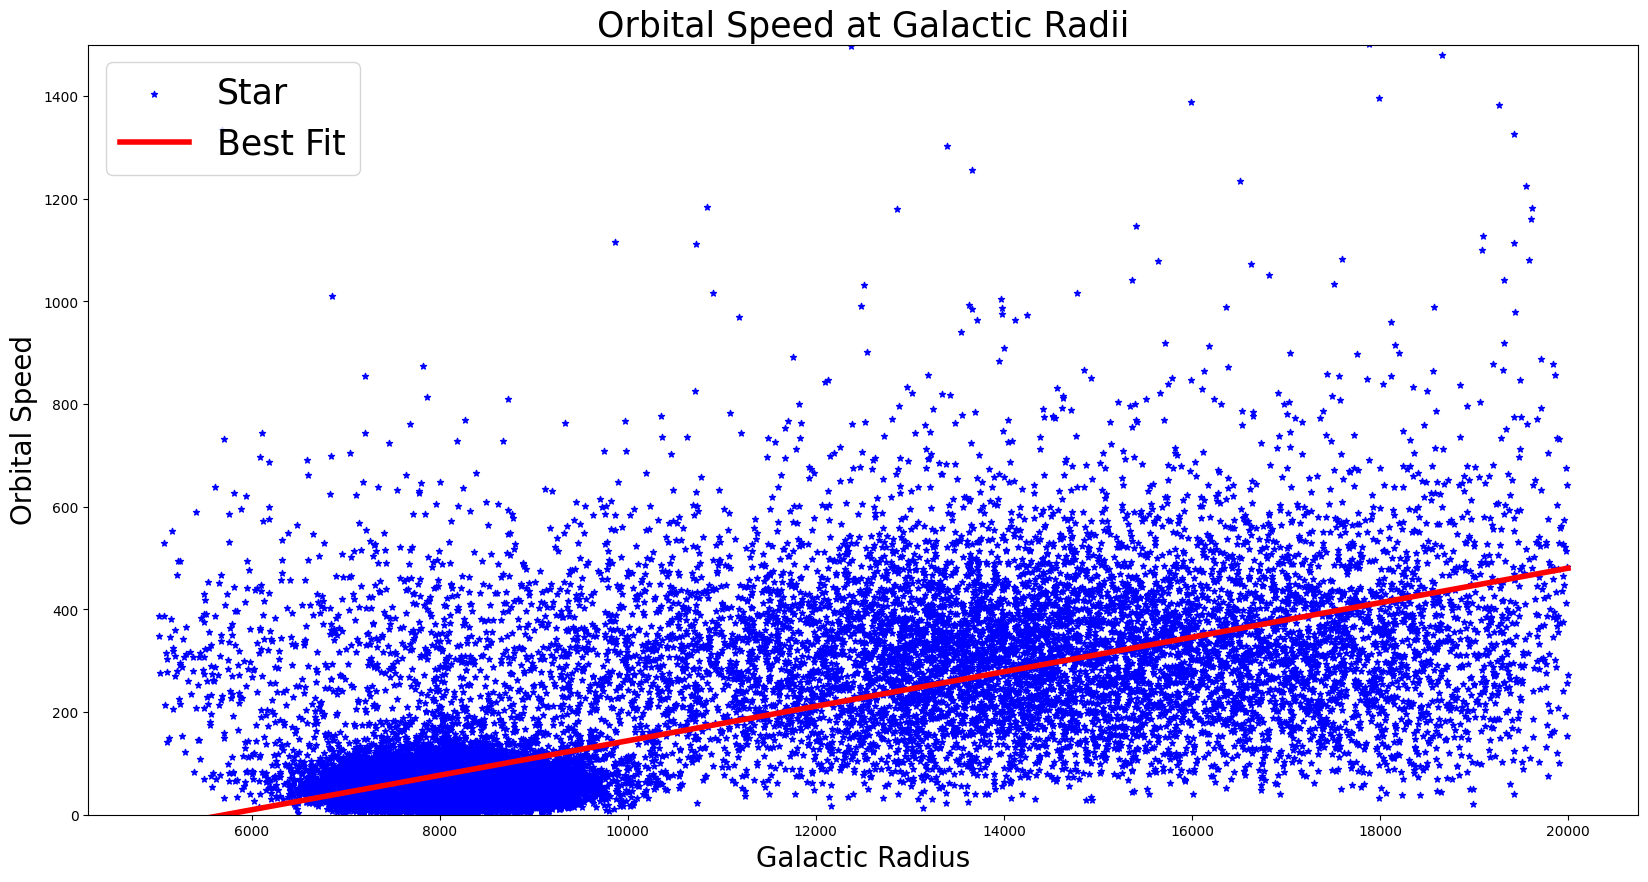

In [484]:
#filter data with more accurate bounds of interests
dfbound1 = df[df['Galactic Radius'] < 20000]
dfbound2 = dfbound1[dfbound1['Orbital Speed'] > 0]
dfnew = dfbound2[dfbound2['Galactic Radius'] > 5000]

#graph new raw data
dfnew.plot.scatter(x='Galactic Radius', y='Orbital Speed', marker='*', color='b', figsize=(20,10), label='Star')
plt.xlabel('Galactic Radius',fontsize = 20)
plt.ylabel('Orbital Speed',fontsize = 20)
x = dfnew['Galactic Radius']
y = dfnew['Orbital Speed']

#fitting equation for velocity and radius
coeff, cov = np.polyfit(x, y, 1, cov=True)
def velocity_by_radius(R):
    return (coeff[0] * R) + coeff[1]
print(coeff)
x_orb = np.linspace(min(x), max(x), 100)
y_orb = velocity_by_radius(x_orb)
plt.plot(x_orb, y_orb, color='red', label='Best Fit', linewidth=4)

#plotting fit
plt.ylim(0,1500)
plt.title('Orbital Speed at Galactic Radii', fontsize = 25)
plt.legend(fontsize = 25)

print('v(r) = ',coeff[0],'R + ',coeff[1])

M(R) = ( 4.736651061564667 +/- 2.524232083863591e-10 )R ^( 4.736651061564667 +/- 0.005377439725047743 )


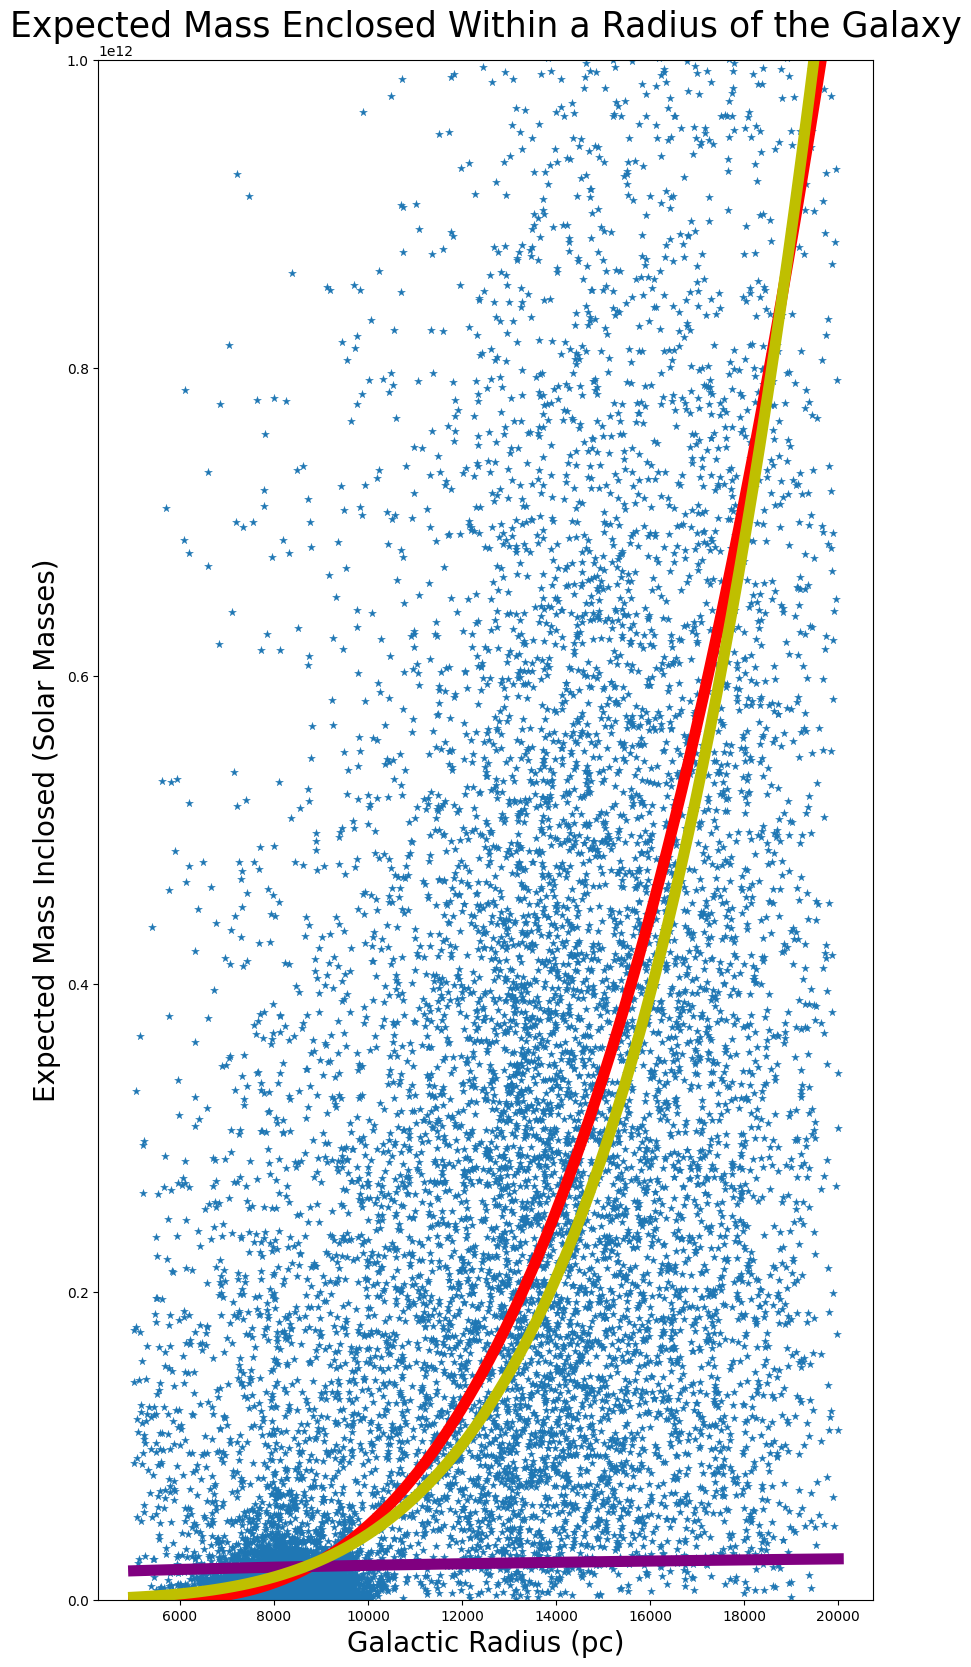

In [490]:
#relating velocity and radius to total mass
def tot_mass_function(v, R):
    return (v*1000)**2 * (R*3.1*10**16) / (6.67*10**-11) / (2*10**30)

v = dfnew['Orbital Speed']
x = dfnew['Galactic Radius']
y = tot_mass_function(coeff[0] * x_values + coeff[1], x_values)

#drawing the fit line for total mass function
x_values = np.linspace(min(x), max(x), 100)
plt.plot(x_values, y, color='red', linewidth=(8),label='Total Matter Best Fit')

#plotting each star's mass to velocity relation:
plt.scatter(x, tot_mass_function(v, x), marker='*', label='Star',linewidth = 0.2)
plt.xlabel('Galactic Radius (pc)', fontsize=20)
plt.ylabel('Expected Mass Inclosed (Solar Masses)',fontsize=20)
plt.title('Expected Mass Enclosed Within a Radius of the Galaxy',fontsize=25)
plt.ylim(0,0.2*10**13)
fig = plt.gcf()
fig.set_size_inches(10, 20)

#previously derived equation based on luminosity-mass relationship
def norm_mass_function(R):
    return 3.2*10**13 * e**-7.67*((R/2000)**(1/4))
    
x_norm = np.linspace(min(x), max(x), 100)
y_norm = norm_mass_function(x_norm)
plt.plot(x_norm, y_norm, color='purple', label='Baryonic Matter Best Fit', linewidth=8, )


#fitting an equation for darkMatter
def darkMatter_mass_function(R, P0, n):
    return P0 * R ** n

x_dark = dfnew['Galactic Radius']
y_dark = tot_mass_function(coeff[0] * x_dark + coeff[1], x_dark) - norm_mass_function(x_dark)
param_array = [p0_est, n_est]
p0_est = 1e-06
n_est = 3
popt, cov_matrix = curve_fit(darkMatter_mass_function, x_dark, y_dark, p0 = [p0_est, n_est])


#graphing the fit equation for darkMatter
def solved_darkMatter_mass_function(R):
    return  popt[0] * (R**popt[1])

x_dark = dfnew['Galactic Radius']
x_dark1 = np.linspace(min(x_dark), max(x_dark), 100)
y_dark1 = solved_darkMatter_mass_function(x_dark1)
plt.plot(x_dark1, y_dark1, color='y', label='DarkMatter Bestfit', linewidth=8)
plt.ylim(0,1e12)
P0_error = math.sqrt(cov_matrix[0,0])
n_error = math.sqrt(cov_matrix[1,1])
print('M(R) = (',popt[1],'+/-',P0_error,')R ^(',popt[1],'+/-',n_error,')')

#graph shows total matter, dark matter, and normal matter as a function of radius in a galaxy,, overlayed on the collected stars

p(r) =  1.1466872490797765e-09  * R ^ 1.7366510615646673


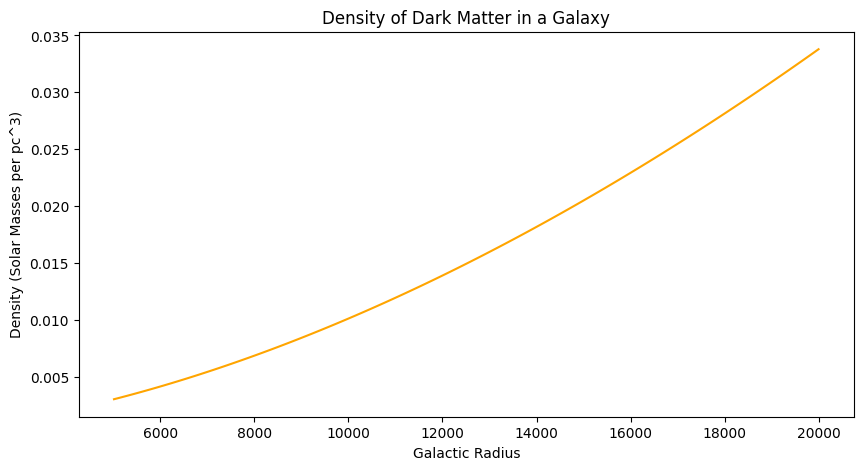

In [487]:
#defining density equation from mass equation for dark matter
def density_darkMatter(R):
    return (3 * popt[0]) / (4*math.pi) * (R**(popt[1] - 3))
x_dens = np.linspace(min(x), max(x), 100)
y_dens = density_darkMatter(x_dens)
plt.plot(x_dens, y_dens, color='orange')
plt.title('Density of Dark Matter in a Galaxy')
plt.xlabel('Galactic Radius')
plt.ylabel('Density (Solar Masses per pc^3)')
fig = plt.gcf()
fig.set_size_inches(10,5)

print('p(r) = ',3*popt[0]/4/math.pi,' * R ^',popt[1] - 3)